# Digit recognition - multiclass classification


## Processing of collected data (not MNIST)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import skimage.io as skio
zeros = skio.imread_collection("website/images/0/*.png")
ones = skio.imread_collection("website/images/1/*.png")
twos = skio.imread_collection("website/images/2/*.png")
threes = skio.imread_collection("website/images/3/*.png")
fours = skio.imread_collection("website/images/4/*.png")
fives = skio.imread_collection("website/images/5/*.png")
sixes = skio.imread_collection("website/images/6/*.png")
sevens = skio.imread_collection("website/images/7/*.png")
eights = skio.imread_collection("website/images/8/*.png")
nines = skio.imread_collection("website/images/9/*.png")

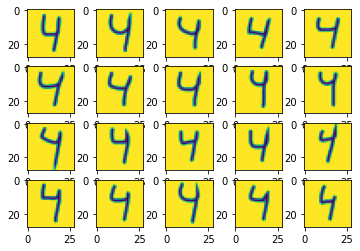

In [5]:
skio.imshow_collection(fours[:20]);

## Inverting, binarizing

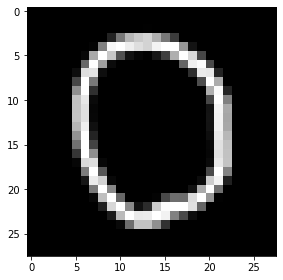

In [6]:
import skimage.color as skclr
import skimage.filters as skfltr


# Standard inverted
zeros_inv = np.invert(zeros[0])
skio.imshow(zeros_inv)

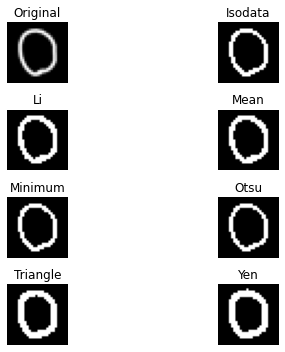

In [7]:
skfltr.try_all_threshold(zeros_inv, verbose=False);

In [8]:
# Choosing Otsu as the best threshold
def binarize_images(image_collection):
    """
    Inverts a collection of images and makes it binary
    """

    imges = []

    for img in image_collection:
        thresh = skfltr.threshold_mean(img)
        binary = img < thresh
        imges.append(binary)
    
    return imges

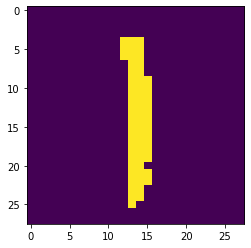

In [9]:
plt.imshow(binarize_images(ones)[7])

In [10]:
zeros = binarize_images(zeros)
ones = binarize_images(ones)
twos = binarize_images(twos)
threes = binarize_images(threes)
fours = binarize_images(fours)
fives = binarize_images(fives)
sixes = binarize_images(sixes)
sevens = binarize_images(sevens)
eights = binarize_images(eights)
nines = binarize_images(nines)

In [12]:
zeros = np.array(zeros).reshape(len(zeros), 28*28)
ones = np.array(ones).reshape(len(ones), 28*28)
twos = np.array(twos).reshape(len(twos), 28*28)
threes = np.array(threes).reshape(len(threes), 28*28)
fours = np.array(fours).reshape(len(fours), 28*28)
fives = np.array(fives).reshape(len(fives), 28*28)
sixes = np.array(sixes).reshape(len(sixes), 28*28)
sevens = np.array(sevens).reshape(len(sevens), 28*28)
eights = np.array(eights).reshape(len(eights), 28*28)
nines = np.array(nines).reshape(len(nines), 28*28)

dfDrawings = pd.DataFrame(np.concatenate([zeros, ones, twos, threes, fours, fives, sixes, sevens, eights, nines]))

In [13]:
dfDrawings.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
def labeler(id):
    """Assigns appropriate label to each observation"""
    if id < (thr := len(zeros)):
        return 0
    elif (id < (thr := thr + len(ones))):
        return 1
    elif (id < (thr := thr + len(twos))):
        return 2
    elif (id < (thr := thr + len(threes))):
        return 3
    elif (id < (thr := thr + len(fours))):
        return 4
    elif (id < (thr := thr + len(fives))):
        return 5
    elif (id < (thr := thr + len(sixes))):
        return 6
    elif (id < (thr := thr + len(sevens))):
        return 7
    elif (id < (thr := thr + len(eights))):
        return 8
    return 9

In [15]:
dfDrawings["label"] = [labeler(i) for i in range(len(dfDrawings))]

In [16]:
dfDrawings

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,9
2480,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,9
2481,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,9
2482,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,9


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

x_train, x_test, y_train, y_test = train_test_split(dfDrawings.iloc[:, :-1], dfDrawings.label, test_size=0.25, shuffle=True, stratify=dfDrawings.label)

logreg = LogisticRegression(penalty="elasticnet", random_state = 112, max_iter=2000, solver="saga", l1_ratio=0.7)
onevrest = OneVsRestClassifier(logreg)

onevrest.fit(x_train, y_train)
score =  onevrest.score(x_test, y_test)
score

0.9822866344605475

In [22]:
dfDrawings.to_csv("drawings2500.csv", index=False)

In [25]:
import pickle

pickle.dump(onevrest, open("models\ovr.pkl", "wb"))

In [27]:
from sklearn.metrics import classification_report

print(classification_report(dfDrawings.label, onevrest.predict(dfDrawings.iloc[:, :-1])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00       150
           2       1.00      0.99      1.00       346
           3       0.99      1.00      0.99       248
           4       0.98      1.00      0.99       249
           5       1.00      1.00      1.00       248
           6       1.00      1.00      1.00       249
           7       1.00      1.00      1.00       248
           8       1.00      1.00      1.00       247
           9       0.99      0.99      0.99       254

    accuracy                           1.00      2484
   macro avg       1.00      1.00      1.00      2484
weighted avg       1.00      1.00      1.00      2484



In [30]:
ovr = pickle.load(open(r"models\ovr.pkl", "rb"))

print(classification_report(dfDrawings.label, ovr.predict(dfDrawings.iloc[:, :-1])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00       150
           2       1.00      0.99      1.00       346
           3       0.99      1.00      0.99       248
           4       0.98      1.00      0.99       249
           5       1.00      1.00      1.00       248
           6       1.00      1.00      1.00       249
           7       1.00      1.00      1.00       248
           8       1.00      1.00      1.00       247
           9       0.99      0.99      0.99       254

    accuracy                           1.00      2484
   macro avg       1.00      1.00      1.00      2484
weighted avg       1.00      1.00      1.00      2484

